In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
housingdata = pd.read_csv('datasets\housing\housing.csv')

In [3]:
housingdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


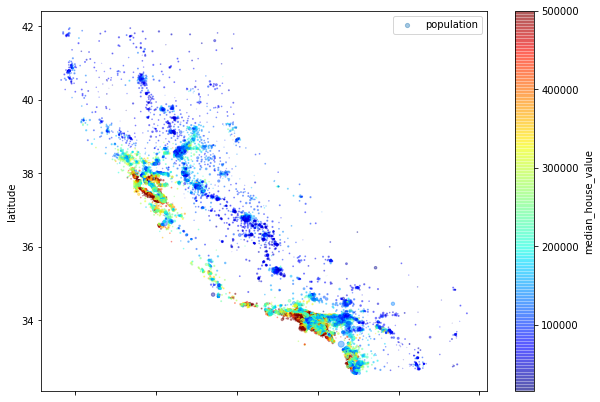

In [13]:
housingdata.plot(kind='scatter',x='longitude', y = 'latitude', alpha=0.4, s=housingdata['population']/1000, 
                 label ='population',c='median_house_value',cmap=plt.get_cmap('jet'), colorbar=True,
                figsize=(10,7))
plt.legend()
plt.show()

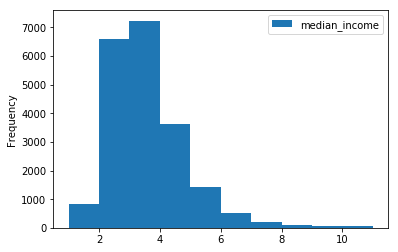

In [26]:
"""
Divide the data set into traing and test
"""
pd.DataFrame(np.ceil(housingdata.median_income/1.5)).plot(kind='hist')



In [30]:
housingdata['income_bucket'] = np.where(np.ceil(housingdata.median_income/1.5)>5,5,np.ceil(housingdata.median_income/1.5))

In [32]:
housingdata['income_bucket'].value_counts()/len(housingdata.income_bucket)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_bucket, dtype: float64

In [34]:
"""
Startified Sampling
"""

from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)


In [35]:
split

StratifiedShuffleSplit(n_splits=1, random_state=42, test_size=0.2,
            train_size=None)

In [39]:
for train_index, test_index in split.split(housingdata, housingdata.income_bucket):
    strat_train_index = housingdata.loc[train_index]
    strat_test_index = housingdata.loc[test_index]

In [40]:
strat_train_index.income_bucket.value_counts()/len(strat_train_index.income_bucket)

3.0    0.350594
2.0    0.318859
4.0    0.176296
5.0    0.114402
1.0    0.039850
Name: income_bucket, dtype: float64

In [41]:
strat_test_index.income_bucket.value_counts()/len(strat_test_index.income_bucket)

3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_bucket, dtype: float64

In [49]:
for set_ in (strat_test_index, strat_train_index):
    set_.drop('income_bucket',axis=1, inplace=True)

ValueError: labels ['income_bucket'] not contained in axis

In [ ]:
housingDataTrain = strat_train_index.copy()


In [50]:
corrValues = housingDataTrain.corr()

In [51]:
corrValues['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

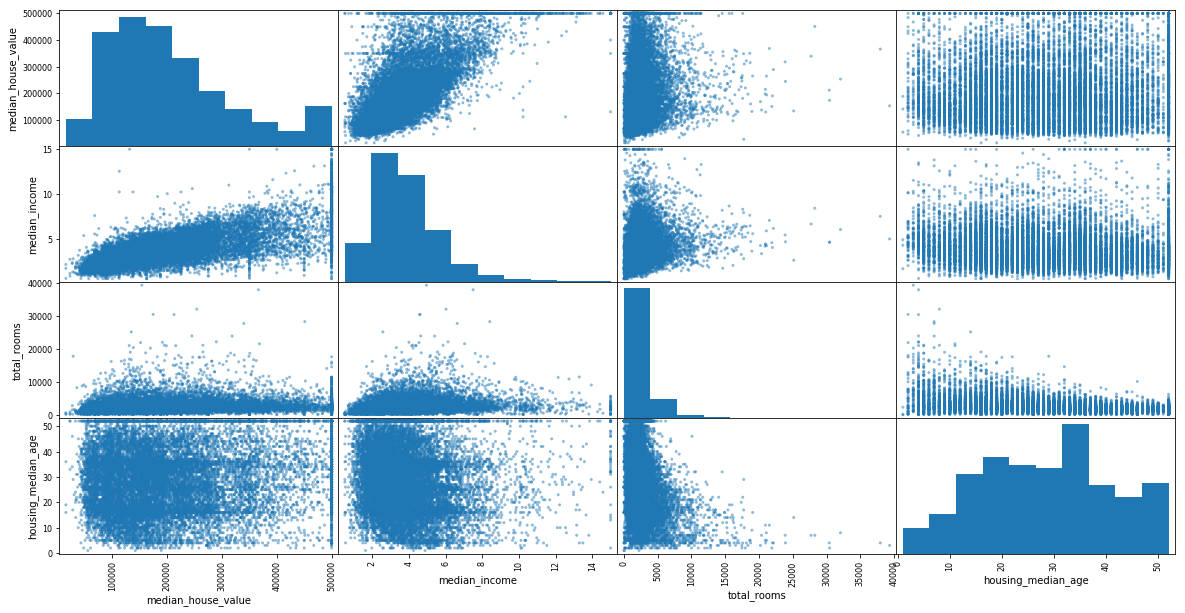

In [54]:
from pandas.plotting import scatter_matrix

attributes = ['median_house_value','median_income','total_rooms','housing_median_age']

scatter_matrix(housingDataTrain[attributes],figsize=(20,10))
plt.show()

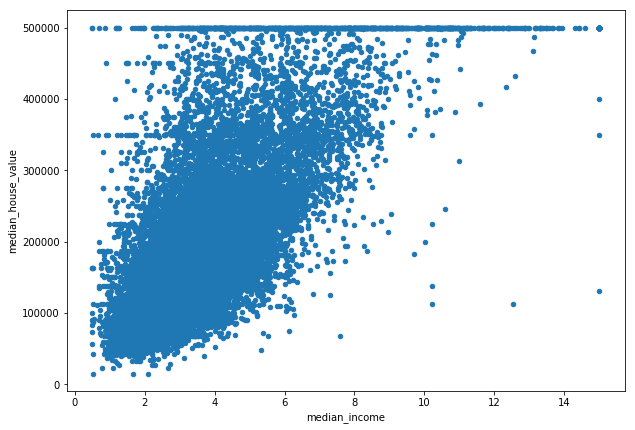

In [56]:
housingDataTrain.plot(kind='scatter',x='median_income',y='median_house_value', figsize=(10,7))
plt.show()

In [57]:
"""
Adding new variables
"""
housingDataTrain['bedrooms_per_room'] = housingDataTrain.total_bedrooms/housingDataTrain.total_rooms

In [58]:
housingDataTrain['rooms_per_houshold'] = housingDataTrain.total_rooms/housingDataTrain.households

In [60]:
corr_matrix = housingDataTrain.corr()

In [63]:
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
rooms_per_houshold    0.146285
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
bedrooms_per_room    -0.259984
Name: median_house_value, dtype: float64

In [64]:
from sklearn.base import BaseEstimator, TransformerMixin
rooms_ix, bedrooms_ix, households_ix =3, 4, 6
class AttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        room_per_household = X[:,rooms_ix]/X[:,households_ix]
        bedrooms_per_room = X[:,bedrooms_ix]/X[:,rooms_ix]
        return np.c_[X, room_per_household, bedrooms_per_room]

In [65]:
class dataframeSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attributes_names):
        self.attributes_names = attributes_names
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return X[self.attributes_names].values

In [81]:
"""
Imputer
"""

housing = strat_train_index.drop('median_house_value', axis=1)
housinng_label = strat_train_index['median_house_value'].copy()
num_attributes = list(housing.drop('ocean_proximity',axis=1))
cat_attributes = ['ocean_proximity']
from sklearn.preprocessing import Imputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import CategoricalEncoder
num_pipeline = Pipeline([
    ('dataselector',dataframeSelector(num_attributes)),
    ('imputer',Imputer(strategy = 'median')),
    ('attributeAdder',AttributesAdder()),
    ('stdScaler',StandardScaler()),
])

cat_pipeline = Pipeline([
    ('dataselector',dataframeSelector(cat_attributes)),
    ('cat_encoder', CategoricalEncoder(encoding='onehot-dense'))
])

In [82]:
from sklearn.pipeline import FeatureUnion
full_pipline = FeatureUnion([
    ('num_pipeline',num_pipeline),
    ('cat_pipeline',cat_pipeline),
])

In [83]:
housingPrepared = full_pipline.fit_transform(housingDataTrain)

In [84]:
housingPrepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [85]:
"""
Import linear regression
"""

from sklearn.linear_model import LinearRegression

linReg = LinearRegression()
linReg.fit(housingPrepared, housinng_label)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [86]:
from sklearn.metrics import mean_squared_error

housingPrediction = linReg.predict(housingPrepared)

In [87]:
linRegMse = mean_squared_error(housinng_label,housingPrediction)

In [88]:
linRegRmse = np.sqrt(linRegMse)

In [89]:
print(linRegRmse)

68635.59352516982


In [90]:
"""
Decision Tree Models
"""

from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housingPrepared, housinng_label)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [91]:
tree_reg_predictions = tree_reg.predict(housingPrepared)
tree_reg_mse = mean_squared_error(housinng_label,tree_reg_predictions)
tree_reg_rmse = np.sqrt(tree_reg_mse)
print(tree_reg_rmse)

0.0


In [92]:
"""
Cross Validation
"""

from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housingPrepared, housinng_label, scoring='neg_mean_squared_error',cv=10)
tree_cv_rmse = np.sqrt(-scores)
print(tree_cv_rmse)

[70581.22896351 64042.08284288 73464.3203644  71102.53572298
 70915.91225068 73956.98317802 71302.91264192 70236.34817188
 68309.5830738  68284.34673394]


In [94]:
np.mean(tree_cv_rmse)

70219.62539440252

In [95]:
np.std(tree_cv_rmse)

2694.816874571582

In [96]:
"""
random forest regressor
"""

from sklearn.ensemble import RandomForestRegressor
rtree_reg = RandomForestRegressor()
rtree_scores = cross_val_score(rtree_reg,housingPrepared, housinng_label, scoring='neg_mean_squared_error', cv=10)
rtree_cv_scores = np.sqrt(-rtree_scores)


In [97]:
np.mean(rtree_cv_scores)

52315.91484188817

In [98]:
np.std(rtree_cv_scores)

2151.8384187863603

In [99]:
"""
Grid search cv
"""

from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators':[3,10,30], 'max_features':[2, 4, 6, 8]},
    {'bootstrap':[False],'n_estimators':[3,10],'max_features':[2, 3, 4]}
]

forest_reg = RandomForestRegressor()

gridSearch = GridSearchCV(forest_reg, param_grid=param_grid,cv=5,scoring='neg_mean_squared_error')

gridSearch.fit(housingPrepared,housinng_label)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=1,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [100]:
gridSearch.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=8, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [101]:
gridSearch.best_params_

{'max_features': 8, 'n_estimators': 30}

In [102]:
gridSearch.cv_results_

c:\users\sneha\desktop\scikitlearndev\scikit-learn\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
c:\users\sneha\desktop\scikitlearndev\scikit-learn\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
c:\users\sneha\desktop\scikitlearndev\scikit-learn\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
c:\users\sneha\desktop\scikitlear

{'mean_fit_time': array([0.06841726, 0.22220378, 0.64907002, 0.08995872, 0.30777569,
        0.92990651, 0.12887516, 0.45438395, 1.34759583, 0.16217241,
        0.5479414 , 1.61568465, 0.09195442, 0.38975644, 0.12765799,
        0.42765713, 0.14142208, 0.48969655]),
 'mean_score_time': array([0.00359054, 0.00897636, 0.02572608, 0.00319185, 0.00898266,
        0.02394238, 0.00339065, 0.00917678, 0.02553167, 0.00319195,
        0.00897017, 0.02412949, 0.00359073, 0.01396422, 0.00379033,
        0.01117053, 0.00398922, 0.01077108]),
 'mean_test_score': array([-4.40525767e+09, -3.25219022e+09, -2.94489168e+09, -3.91539369e+09,
        -2.91134840e+09, -2.70260396e+09, -3.81464880e+09, -2.87738653e+09,
        -2.65096619e+09, -3.65551392e+09, -2.81025079e+09, -2.59995041e+09,
        -4.05572801e+09, -3.13000508e+09, -3.76070196e+09, -2.97377879e+09,
        -3.61185448e+09, -2.82900162e+09]),
 'mean_train_score': array([-1.18441075e+09, -6.12137337e+08, -4.55998117e+08, -1.03119641e+09,
 

In [113]:
feature_importance = gridSearch.best_estimator_.feature_importances_

In [111]:
categories = list(cat_pipeline.named_steps['cat_encoder'].categories_[0])

In [112]:
extra_attributes = ['rooms_per_household','bedrooms_per_room']
all_attributes = num_attributes + extra_attributes + categories

In [131]:
FeatImp = pd.DataFrame(sorted(zip(feature_importance,all_attributes),reverse=True),columns=['Score','ColumnName']).sort_values('Score',ascending=False)

In [132]:
FeatImp

Score           ColumnName
0   0.397778        median_income
1   0.149732               INLAND
2   0.098744            longitude
3   0.085243             latitude
4   0.059607    bedrooms_per_room
5   0.051189  rooms_per_household
6   0.047723   housing_median_age
7   0.030184           population
8   0.022730       total_bedrooms
9   0.021269          total_rooms
10  0.019924           households
11  0.006449            <1H OCEAN
12  0.005949           NEAR OCEAN
13  0.003441             NEAR BAY
14  0.000038               ISLAND

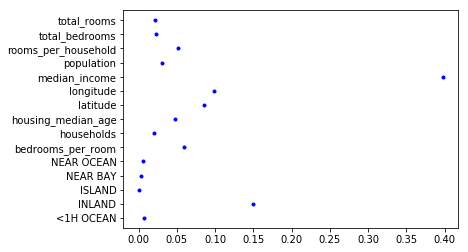

In [135]:
plt.plot(FeatImp.Score,FeatImp.ColumnName,  'b.')

In [137]:
"""
Final Model
"""

finalModel = gridSearch.best_estimator_

X_test = strat_test_index.drop('median_house_value',axis=1)
y_test = strat_test_index['median_house_value'].copy()

X_prepared = full_pipline.transform(X_test)

In [139]:
test_prediction = finalModel.predict(X_prepared)

In [140]:
test_mse = mean_squared_error(y_test, test_prediction)

In [141]:
test_rmse = np.sqrt(test_mse)

In [142]:
print(test_rmse)

48131.15606595774
